In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance


In [2]:
#import dataframe including factors from EDA
df = pd.read_csv('lifestyle_inclfactors.csv', index_col=0)

In [3]:
#check dataframe
df.head(5)

,fruits_veggies,daily_stress,places_visited,core_circle,supporting_others,social_network,achievement,donation,todo_completed,flow,...,F_red1_fulfilment,F_red2_health,F_red3_social,sc_social,sc_stress,sc_fulfilment,sc_health,sc2_fulfilment,sc2_health,sc2_social
0,3,2,2,5,0,5,2,0,6,4,...,-0.475952,-0.402601,-1.147126,0.285728,0.497800,0.362180,0.570083,0.304704,0.446440,0.332707
1,2,3,4,3,8,10,5,2,5,2,...,-0.060676,-0.791953,0.220647,0.503090,0.412767,0.392330,0.507113,0.367362,0.383628,0.552313
2,2,3,3,4,4,10,3,2,2,2,...,0.411631,-1.665557,0.042796,0.400175,0.543626,0.543218,0.405798,0.438625,0.242695,0.523758
3,3,3,10,3,10,7,2,5,3,5,...,-1.221881,-0.532150,1.362556,0.728148,0.615989,0.254997,0.419243,0.192156,0.425541,0.735656
4,5,1,3,3,10,4,2,4,5,0,...,-1.667130,0.721486,0.446708,0.629167,0.220288,0.135818,0.585134,0.124976,0.627783,0.588609


In [4]:
df.columns

Index(['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle',
       'supporting_others', 'social_network', 'achievement', 'donation',
       'todo_completed', 'flow', 'daily_steps', 'live_vision', 'sleep_hours',
       'lost_vacation', 'daily_shouting', 'sufficient_income',
       'personal_awards', 'time_for_passion', 'weekly_meditation', 'age',
       'gender', 'work_life_balance_score', 'healthy_bmi', 'quest_year',
       'quest_month', 'F1_social', 'F2_stress', 'F3_fulfilment', 'F4_health',
       'F_red1_fulfilment', 'F_red2_health', 'F_red3_social', 'sc_social',
       'sc_stress', 'sc_fulfilment', 'sc_health', 'sc2_fulfilment',
       'sc2_health', 'sc2_social'],
      dtype='object')

# Classification with healthy BMI as target

In [68]:
# select all possible features and target
X = df[['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle',
       'supporting_others', 'social_network', 'achievement', 'donation',
       'todo_completed', 'flow', 'daily_steps', 'live_vision', 'sleep_hours',
       'lost_vacation', 'daily_shouting', 'sufficient_income',
       'personal_awards', 'time_for_passion', 'weekly_meditation','sc_social',
       'sc_stress', 'sc_fulfilment', 'sc_health', 'sc2_fulfilment',
       'sc2_health', 'sc2_social']]

y = df['healthy_bmi']

### Feature selection: K-Best: checking, if components or single features are better predictors, using Chi2 score

In [8]:
model = SelectKBest(chi2).fit(X, y)
scores = pd.DataFrame(data = (model.scores_), columns = ['score'])
scores = pd.concat((scores, round(pd.DataFrame(data = (model.pvalues_), columns = ['p_value']),4)), axis = 1)
scores['Column'] = X.columns

# Sorting data
print(scores.sort_values(by = ['score'], ascending = False))

         score  p_value             Column
10  404.399153   0.0000        daily_steps
2   391.479875   0.0000     places_visited
18  142.889904   0.0000  weekly_meditation
14  142.446682   0.0000     daily_shouting
13  101.829957   0.0000      lost_vacation
0    98.301883   0.0000     fruits_veggies
7    84.229346   0.0000           donation
1    73.747403   0.0000       daily_stress
8    72.384422   0.0000     todo_completed
4    44.660262   0.0000  supporting_others
12   31.449046   0.0000        sleep_hours
24   21.160916   0.0000         sc2_health
9    20.118419   0.0000               flow
22   16.787525   0.0000          sc_health
3    15.880172   0.0001        core_circle
6    11.730707   0.0006        achievement
16    9.747078   0.0018    personal_awards
5     9.332544   0.0023     social_network
20    4.774797   0.0289          sc_stress
25    2.006158   0.1567         sc2_social
19    1.731074   0.1883          sc_social
17    1.334207   0.2481   time_for_passion
15    0.604

### Looks like the single variables are better predictors than the components.
### Taking out non significant features on 0.05 level (time for passion, sufficient income, live vision) and check correlations between remaining features

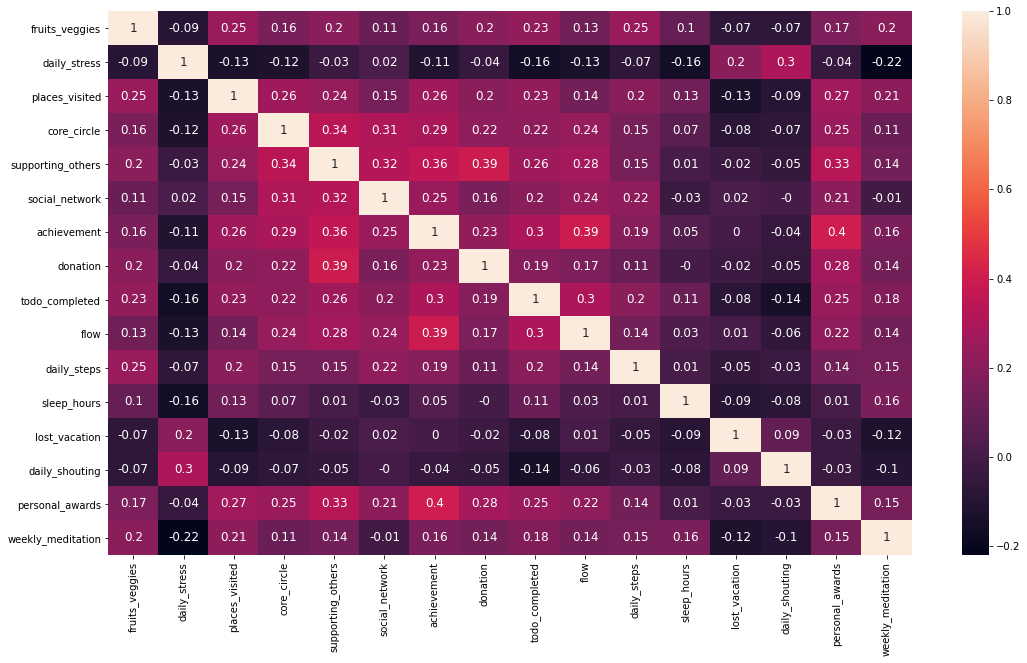

In [9]:
# correlation between the features
X = df[['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle',
       'supporting_others', 'social_network', 'achievement', 'donation',
       'todo_completed', 'flow', 'daily_steps', 'sleep_hours',
       'lost_vacation', 'daily_shouting','personal_awards', 'weekly_meditation']]

fig, ax = plt.subplots(figsize=(18,10))
sn.heatmap(round(X.corr(),2), annot=True, annot_kws={"size": 12})
plt.show()

### looking at correlations higher than 0.3: core circle (2), supporting others (5) , social network (2), achievement (3), donation (1), flow (1), personal awards (2) --> taking out supporting others and achievement

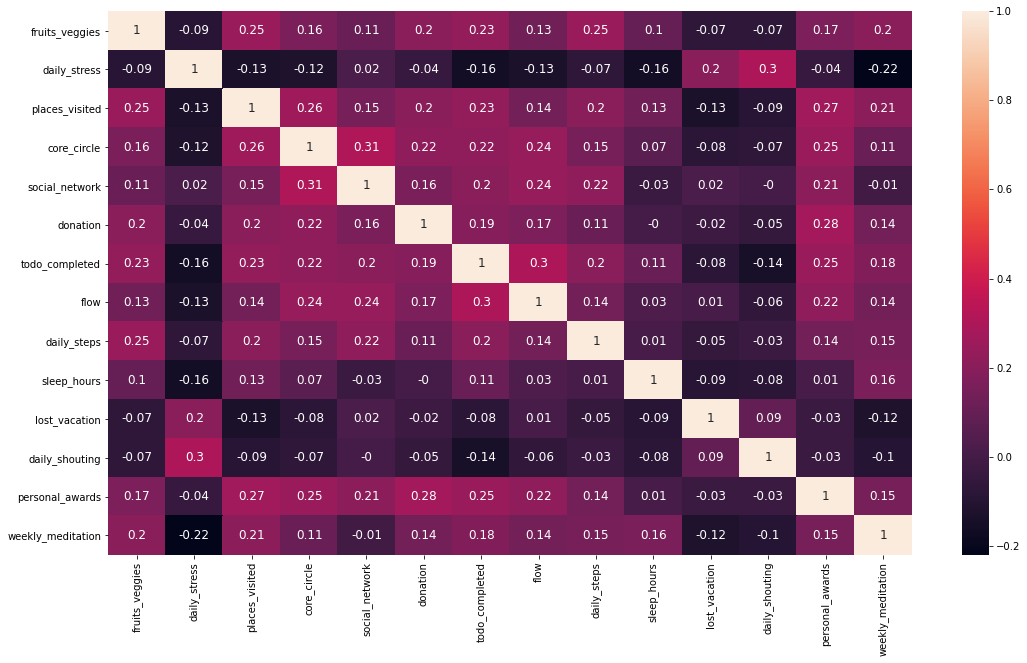

In [69]:
# correlation between the features
X = df[['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle', 'social_network', 'donation', 'todo_completed',
        'flow', 'daily_steps', 'sleep_hours', 'lost_vacation', 'daily_shouting','personal_awards', 'weekly_meditation']]

fig, ax = plt.subplots(figsize=(18,10))
sn.heatmap(round(X.corr(),2), annot=True, annot_kws={"size": 12})
plt.show()

# Run Logistic Regression as base model

In [9]:
X = df[['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle', 'social_network', 'donation', 'todo_completed',
        'flow', 'daily_steps', 'sleep_hours', 'lost_vacation', 'daily_shouting','personal_awards', 'weekly_meditation']]

y = df['healthy_bmi']

In [16]:
# define function for running a model (incl. preprocessing) and print score and confusion matrix

def run_model(model_input):
    # train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
    
    # transform with standard scaler
    transformer = StandardScaler().fit(X_train)
    X_train = transformer.transform(X_train)
    X_test = transformer.transform(X_test)

    # define model und fit train data
    model = model_input.fit(X_train, y_train)

    # predict target
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    # Model validation
    print(classification_report(y_train, y_train_predict))
    print(classification_report(y_test, y_test_predict))

    # plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict)
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict)
    plt.show()

              precision    recall  f1-score   support

           0       0.57      0.32      0.41      4919
           1       0.64      0.83      0.72      7060

    accuracy                           0.62     11979
   macro avg       0.61      0.58      0.57     11979
weighted avg       0.61      0.62      0.59     11979

              precision    recall  f1-score   support

           0       0.58      0.32      0.41      1640
           1       0.64      0.84      0.72      2353

    accuracy                           0.62      3993
   macro avg       0.61      0.58      0.57      3993
weighted avg       0.61      0.62      0.59      3993



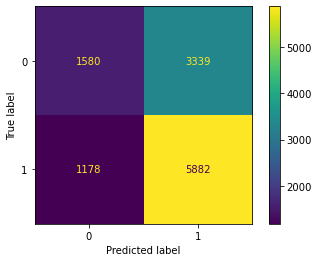

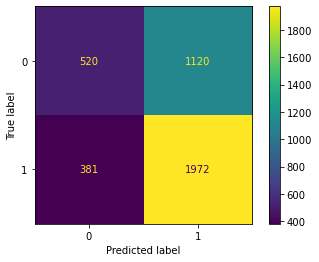

In [17]:
run_model(LogisticRegression(random_state=42))

### Issues with recall and prediction of smaller group: Undersampling bigger group for train data

In [4]:
# update the function with RandomUndersampler

def run_model(model_input):
    # train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
    
    # Undersampling bigger group (group 1)
    rus = RandomUnderSampler(random_state = 42)
    X_train, y_train = rus.fit_resample(X_train,y_train)
    print('y_train after undersampling')
    print(y_train.value_counts())
    
    # transform with standard scaler
    transformer = StandardScaler().fit(X_train)
    X_train = transformer.transform(X_train)
    X_test = transformer.transform(X_test)

    # define model und fit train data
    model = model_input.fit(X_train, y_train)

    # predict target
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    # Model validation
    print(classification_report(y_train, y_train_predict))
    print(classification_report(y_test, y_test_predict))

    # plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict)
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict)
    plt.show()

y_train after undersampling
0    4919
1    4919
Name: healthy_bmi, dtype: int64
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      4919
           1       0.60      0.60      0.60      4919

    accuracy                           0.60      9838
   macro avg       0.60      0.60      0.60      9838
weighted avg       0.60      0.60      0.60      9838

              precision    recall  f1-score   support

           0       0.50      0.60      0.54      1640
           1       0.68      0.59      0.63      2353

    accuracy                           0.59      3993
   macro avg       0.59      0.59      0.59      3993
weighted avg       0.60      0.59      0.59      3993



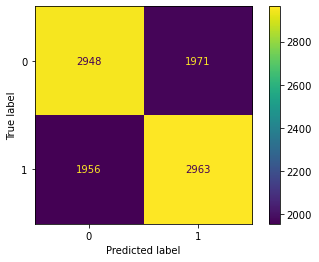

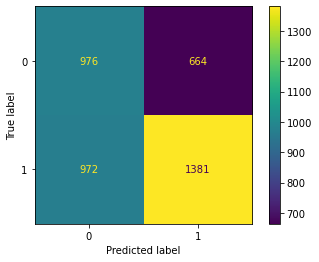

In [28]:
run_model(LogisticRegression(random_state=42))

### Even though accuracy for group 1 decreased, accuracy for group 2 increased, confusion matrix much more balanced.

# Trying different classification models with cross validation

In [33]:
# define function to cross validate different model

def validate_models(models):
    
    all_scores = {}
    for model in models:
        
        # train-test-split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
        
        # make pipeline of preprocessing and model
        classifier = make_pipeline(RandomUnderSampler(random_state = 42), StandardScaler(), model)
        
        # get cross validation scores for 25 folds
        scores = cross_val_score(classifier, X_train, y_train, cv=25)
        
        # save scores in a dictionairy
        all_scores[str(model)[:12]] = scores
        
    # create dataframe with all models and scores
    bp = pd.DataFrame(all_scores)
    
    #create boxplot to view mean cv score and distribution
    fig, ax = plt.subplots(figsize = (2*len(models),5))
    sn.boxplot(data = bp)
    plt.show()

### Using cross validation on different feature sets

>>>>>>> Index(['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle',
       'social_network', 'donation', 'todo_completed', 'flow', 'daily_steps',
       'sleep_hours', 'lost_vacation', 'daily_shouting', 'personal_awards',
       'weekly_meditation'],
      dtype='object')


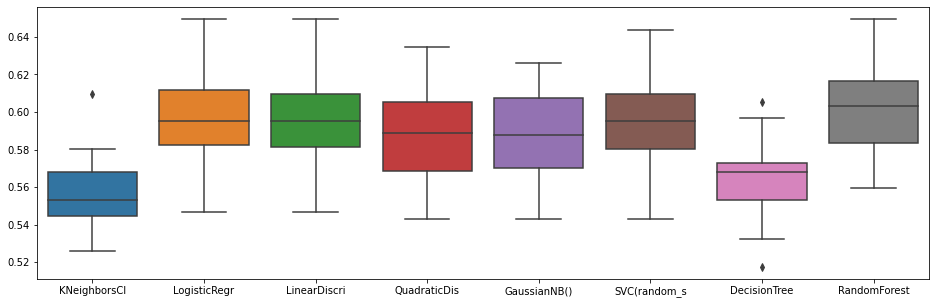

 
>>>>>>> Index(['F1_social', 'F2_stress', 'F3_fulfilment', 'F4_health'], dtype='object')


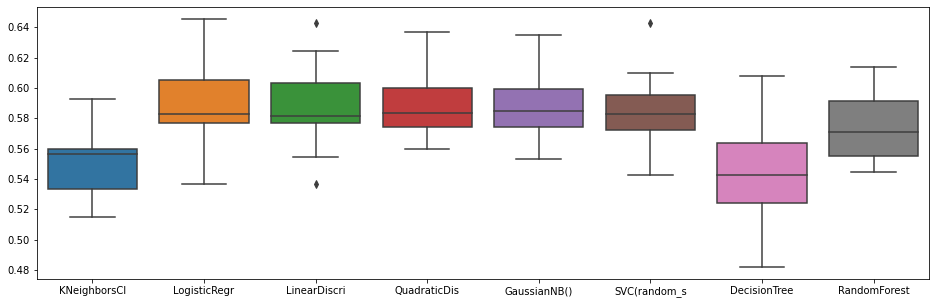

 
>>>>>>> Index(['F_red1_fulfilment', 'F_red2_health', 'F_red3_social'], dtype='object')


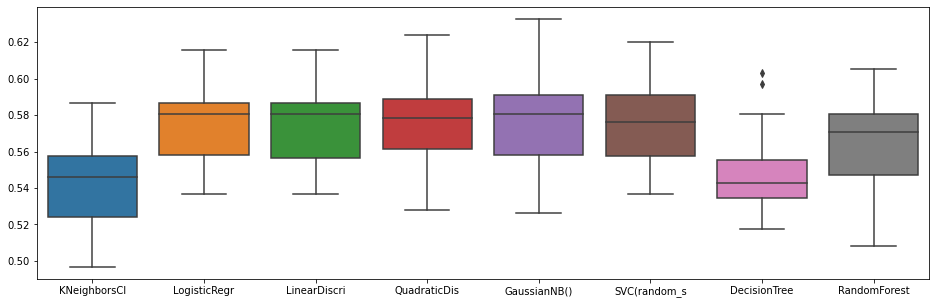

In [34]:
X_all = df[['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle', 'social_network', 'donation', 'todo_completed',
        'flow', 'daily_steps', 'sleep_hours', 'lost_vacation', 'daily_shouting','personal_awards', 'weekly_meditation']]

X_4 = df[['F1_social', 'F2_stress', 'F3_fulfilment', 'F4_health']]

X_3 = df[['F_red1_fulfilment', 'F_red2_health', 'F_red3_social']]

y = df['healthy_bmi']

feature_sets = [X_all, X_4, X_3]

for X in feature_sets:
    
    print('>>>>>>>', X.columns)
    
    # validate models
    validate_models([KNeighborsClassifier(), LogisticRegression(random_state=42), LinearDiscriminantAnalysis(), 
                     QuadraticDiscriminantAnalysis(), GaussianNB(), SVC(random_state=42),
                     DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)])
    print(' ')

### Performances are close together but slightly better for all single features (X_all) compared to components (X_3 and X_4). Within X_all, RandomForestClassifier seems to be the most promising model

# Random Forest Classification on single features, parameter tuning

y_train after undersampling
0    4919
1    4919
Name: healthy_bmi, dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4919
           1       1.00      1.00      1.00      4919

    accuracy                           1.00      9838
   macro avg       1.00      1.00      1.00      9838
weighted avg       1.00      1.00      1.00      9838

              precision    recall  f1-score   support

           0       0.51      0.62      0.56      1640
           1       0.69      0.59      0.63      2353

    accuracy                           0.60      3993
   macro avg       0.60      0.60      0.60      3993
weighted avg       0.62      0.60      0.60      3993



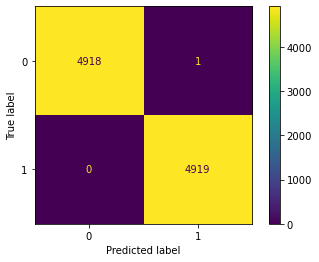

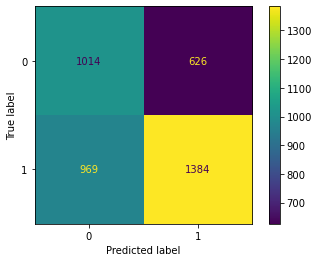

In [55]:
# base model
X = df[['fruits_veggies', 'daily_stress', 'places_visited', 'core_circle', 'social_network', 'donation', 'todo_completed',
        'flow', 'daily_steps', 'sleep_hours', 'lost_vacation', 'daily_shouting','personal_awards', 'weekly_meditation']]
y = df['healthy_bmi']

run_model(RandomForestClassifier(random_state=42))

## GridSearch for Parameter tuning

In [36]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
    
# Undersampling bigger group (group 1)
rus = RandomUnderSampler(random_state = 42)
X_train, y_train = rus.fit_resample(X_train,y_train)
print('y_train after undersampling')
print(y_train.value_counts())
    
# transform with standard scaler
transformer = StandardScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

rfc = RandomForestClassifier(random_state=42)
parameters = { 
    'n_estimators': [100, 250, 500, 1000],
    'criterion' :['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [10, 20, 20, 30]}

rfc_grid = GridSearchCV(estimator=rfc, param_grid=parameters, cv= 25)
rfc_grid.fit(X_train, y_train)

y_train after undersampling
0    4919
1    4919
Name: healthy_bmi, dtype: int64


GridSearchCV(cv=25, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 250, 500, 1000]})

In [37]:
gridresults = pd.DataFrame(rfc_grid.cv_results_)
gridresults.to_csv('gridsearchresults.csv')

In [38]:
rfc_grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       n_estimators=1000, random_state=42)

In [39]:
rfc_grid.best_score_

0.6158768292840443

#### checking csv of all results: almost no different between best estimator with 1000 n_estimators and the version with 250 estimators. Choosing 250 estimators.

### Run model again with best estimator from GridSearch

y_train after undersampling
0    4919
1    4919
Name: healthy_bmi, dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4919
           1       1.00      1.00      1.00      4919

    accuracy                           1.00      9838
   macro avg       1.00      1.00      1.00      9838
weighted avg       1.00      1.00      1.00      9838

              precision    recall  f1-score   support

           0       0.52      0.62      0.57      1640
           1       0.70      0.61      0.65      2353

    accuracy                           0.61      3993
   macro avg       0.61      0.61      0.61      3993
weighted avg       0.62      0.61      0.61      3993



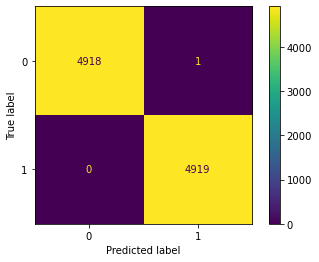

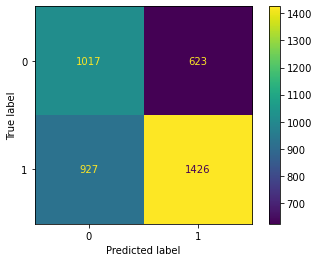

In [6]:
run_model(RandomForestClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       n_estimators=250, random_state=42))

## Feature importances

### 1: Build in feature importance of random forest

In [108]:
importance = rfc.feature_importances_
importance_mdi = pd.DataFrame(importance, index=X.columns, columns=['mdi'])
importance_mdi  = importance_mdi.sort_values(['mdi'], ascending=False)

Text(0, 0.5, 'Permutation importance')

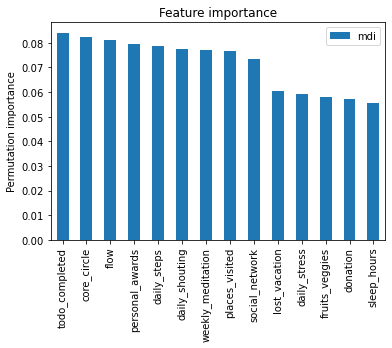

In [96]:
# plot importances
importance_mdi.plot.bar()
plt.title("Feature importance")
plt.ylabel("Permutation importance")

### 2: Importance using permutation

In [109]:
importance = permutation_importance(rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
importance_perm = pd.DataFrame(importance.importances_mean, index=X.columns, columns=['permutation'])
importance_perm  = importance_perm.sort_values(['permutation'], ascending=False)

Text(0, 0.5, 'Permutation importance')

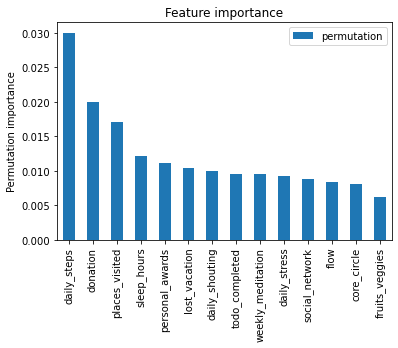

In [75]:
# plot importances
importance_perm.plot.bar()
plt.title("Feature importance")
plt.ylabel("Permutation importance")

### 3: Get also KBest values again

In [110]:
kbest = SelectKBest(chi2).fit(X, y)
importance_kbest = pd.DataFrame(data = (kbest.scores_), index = X.columns, columns = ['kbest'])

# Sorting data
print(importance_kbest.sort_values(by = ['kbest'], ascending = False))

                        kbest
daily_steps        404.399153
places_visited     391.479875
weekly_meditation  142.889904
daily_shouting     142.446682
lost_vacation      101.829957
fruits_veggies      98.301883
donation            84.229346
daily_stress        73.747403
todo_completed      72.384422
sleep_hours         31.449046
flow                20.118419
core_circle         15.880172
personal_awards      9.747078
social_network       9.332544


## Calculating an importance scale of average importance for each feature between 0 (not important at all) and 10 (very important)

In [111]:
# add dummy row with importance of 0 to have min = 0 and max = max of score
dummy = pd.DataFrame([0], columns =['permutation'], index=['dummy'])
importance_perm = importance_perm.append(dummy)

dummy2 = pd.DataFrame([0], columns =['mdi'], index=['dummy'])
importance_mdi = importance_mdi.append(dummy2)

dummy2 = pd.DataFrame([0], columns =['kbest'], index=['dummy'])
importance_kbest = importance_kbest.append(dummy2)

# concatenate importances
feature_importance = pd.concat((importance_perm, importance_mdi), axis = 1)
feature_importance = pd.concat((feature_importance, importance_kbest), axis = 1)

# use MinMaxScaler to scale scores
scaler = MinMaxScaler().fit(feature_importance)
feature_importance = pd.DataFrame(scaler.transform(feature_importance), index = feature_importance.index, columns = ['perm_scaled', 'mdi_scaled', 'kbest_scaled'])

# calculate average importance of all three values
feature_importance['importance'] = (feature_importance['perm_scaled']+feature_importance['mdi_scaled']+feature_importance['kbest_scaled'])/3

# get scale to range of 0 to 10
feature_importance['importance'] = round(((feature_importance['importance'])*10),2)
feature_importance['rank'] = feature_importance['importance'].rank(method='min', ascending=False)
feature_importance.sort_values(['rank'])

,perm_scaled,mdi_scaled,kbest_scaled,importance,rank
daily_steps,1.000000,0.933574,1.000000,9.78,1.0
places_visited,0.567973,0.909712,0.968053,8.15,2.0
daily_shouting,0.331943,0.920546,0.352243,5.35,3.0
weekly_meditation,0.316097,0.915007,0.353339,5.28,4.0
donation,0.665555,0.677549,0.208283,5.17,5.0
todo_completed,0.316097,1.000000,0.178993,4.98,6.0
personal_awards,0.369475,0.943444,0.024103,4.46,7.0
lost_vacation,0.346122,0.717847,0.251806,4.39,8.0
flow,0.278565,0.964347,0.049749,4.31,9.0
core_circle,0.269391,0.978897,0.039269,4.29,10.0


# Prepare Dataframe for presentation

In [143]:
# for dimensions of lifestyle using the 4 component solution. Turning minmax scaled factor values into score of 0 to 100%

df[['sc_social','sc_stress', 'sc_fulfilment', 'sc_health']].describe()

,sc_social,sc_stress,sc_fulfilment,sc_health
count,15972.000000,15972.000000,15972.000000,15972.000000
mean,0.520864,0.439025,0.394453,0.563539
std,0.155457,0.158808,0.149641,0.134729
min,0.000000,0.000000,0.000000,0.000000
25%,0.410074,0.323641,0.282981,0.470347
50%,0.522134,0.427673,0.378607,0.566421
75%,0.632102,0.543344,0.491436,0.658640
max,1.000000,1.000000,1.000000,1.000000


In [144]:
df[['sc_social','sc_stress', 'sc_fulfilment', 'sc_health']] = df[['sc_social','sc_stress', 'sc_fulfilment', 'sc_health']]*100
df[['sc_social','sc_stress', 'sc_fulfilment', 'sc_health']].describe()

,sc_social,sc_stress,sc_fulfilment,sc_health
count,15972.000000,15972.000000,15972.000000,15972.000000
mean,52.086398,43.902506,39.445312,56.353937
std,15.545710,15.880840,14.964139,13.472948
min,0.000000,0.000000,0.000000,0.000000
25%,41.007391,32.364128,28.298127,47.034724
50%,52.213351,42.767255,37.860657,56.642133
75%,63.210209,54.334386,49.143604,65.864007
max,100.000000,100.000000,100.000000,100.000000


In [153]:
df[['sc_social','sc_stress', 'sc_fulfilment', 'sc_health']] = round(df[['sc_social','sc_stress', 'sc_fulfilment', 'sc_health']],2)

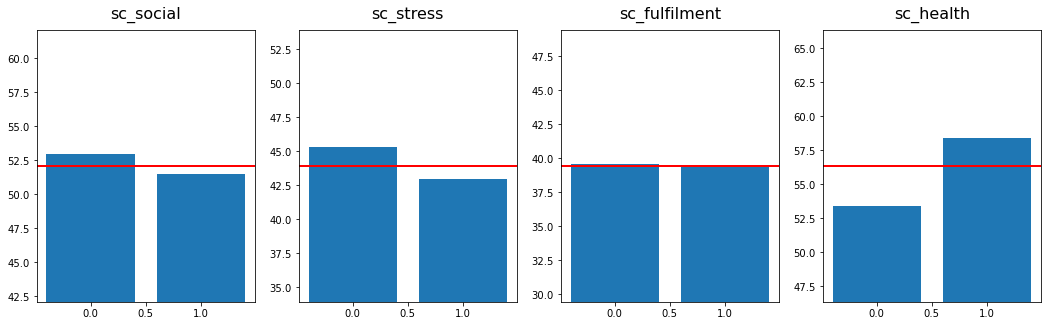

In [154]:
# check values for both target groups healthy bmi = 1 and healthy bmi = 0
fig, ax = plt.subplots(1, 4, figsize = (18,5))

plots = ('sc_social','sc_stress', 'sc_fulfilment', 'sc_health')
b = 0

for column in plots:
    avg = df.groupby('healthy_bmi')[column].mean().to_dict()
    ax[b].bar(avg.keys(), avg.values())
    ax[b].axhline(df[column].mean(), color='red', linewidth=2)
    ax[b].set_title(column, size=16, y = 1.02)
    ax[b].set_ylim(df[column].mean()-10,df[column].mean()+10)
    b = b+1

## Another visualization

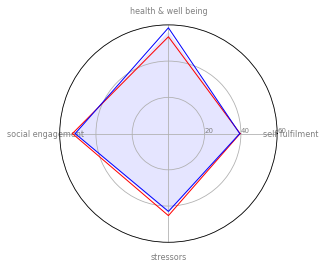

In [209]:
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values1=df[df['healthy_bmi']== 0][['sc_fulfilment', 'sc_health', 'sc_social', 'sc_stress']].mean().values.flatten().tolist()
values1 += values1[:1]
values1

values2=df[df['healthy_bmi']==1][['sc_fulfilment', 'sc_health', 'sc_social', 'sc_stress']].mean().values.flatten().tolist()
values2 += values2[:1]
values2

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(4) * 2 * pi for n in range(4)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], ['self fulfilment', 'health & well being', 'social engagement', 'stressors'], color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([20,40,60], ["20","40","60"], color="grey", size=7)
plt.ylim(0,60)
 
# Plot data
ax.plot(angles, values1, linewidth=1, linestyle='solid', color='red')
ax.plot(angles, values2, linewidth=1, linestyle='solid', color='blue')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

# Show the graph
plt.show()

In [4]:
# drop all other columns of the factor analysis/PCA, as well as
# quest_month, sufficient_income and work-life-balance score, as these are not part of the analysis

df = df.drop(['work_life_balance_score', 'sufficient_income','quest_month', 'F1_social', 'F2_stress', 'F3_fulfilment', 'F4_health',
       'F_red1_fulfilment', 'F_red2_health', 'F_red3_social', 'sc2_fulfilment',
       'sc2_health', 'sc2_social'], axis = 1)

In [5]:
df.describe()

,fruits_veggies,daily_stress,places_visited,core_circle,supporting_others,social_network,achievement,donation,todo_completed,flow,...,daily_shouting,personal_awards,time_for_passion,weekly_meditation,healthy_bmi,quest_year,sc_social,sc_stress,sc_fulfilment,sc_health
count,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,...,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000
mean,2.922677,2.791573,5.232970,5.508077,5.616454,6.474267,4.000751,2.715314,5.745993,3.194778,...,2.930879,5.711558,3.326572,6.233346,0.589344,2017.656148,0.520864,0.439025,0.394453,0.563539
std,1.442694,1.367831,3.311912,2.840334,3.242021,3.086672,2.755837,1.851586,2.624097,2.357518,...,2.676301,3.089630,2.729293,3.016571,0.491968,1.789001,0.155457,0.158808,0.149641,0.134729
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,3.000000,3.000000,4.000000,2.000000,1.000000,4.000000,1.000000,...,1.000000,3.000000,1.000000,4.000000,0.000000,2016.000000,0.410074,0.323641,0.282981,0.470347
50%,3.000000,3.000000,5.000000,5.000000,5.000000,6.000000,3.000000,3.000000,6.000000,3.000000,...,2.000000,5.000000,3.000000,7.000000,1.000000,2017.000000,0.522134,0.427673,0.378607,0.566421
75%,4.000000,4.000000,8.000000,8.000000,10.000000,10.000000,6.000000,5.000000,8.000000,5.000000,...,4.000000,9.000000,5.000000,10.000000,1.000000,2019.000000,0.632102,0.543344,0.491436,0.658640
max,5.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,1.000000,2021.000000,1.000000,1.000000,1.000000,1.000000


In [164]:
# save data
df.to_csv('presentation_data.csv', sep=';', decimal=',')